In [112]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [337]:
import emcee, corner
import numpy as np
import matplotlib.pylab as plt
from scipy.interpolate import interp1d
from pythsolver import solve_model, drawgraph
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
from scipy.optimize import minimize


## test MCMC avec emcee

https://emcee.readthedocs.io/en/stable/tutorials/quickstart/

https://corner.readthedocs.io/en/latest/api.html

In [114]:
# np.show_config()

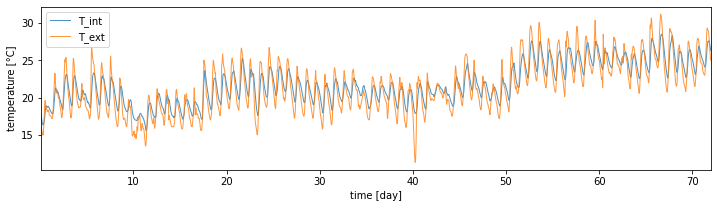

In [440]:
# ===========
#  Load data
# ===========

filename = 'graph.csv'
data = np.genfromtxt(filename, delimiter=',', skip_header=1)
time_sec_raw, T_int_raw, T_ext_raw = data.T

# Interpolation to regular time sampling
dt = 0.5 *3600 # seconds
time_sec = np.arange(time_sec_raw.min(), time_sec_raw.max(), dt)
T_int = interp1d(time_sec_raw, T_int_raw, kind='cubic')(time_sec)
T_ext = interp1d(time_sec_raw, T_ext_raw, kind='cubic')(time_sec)

N = len(time_sec)
time  = time_sec[:N]
T_int = T_int[:N]
T_ext = T_ext[:N]

# Graph
plt.figure(figsize=(12, 3));
plt.plot(time/3600/24, T_int, label='T_int', linewidth=1, alpha=0.8);
plt.plot(time/3600/24, T_ext, label='T_ext', linewidth=1, alpha=0.8);
plt.xlim([np.min(time)/3600/24, np.max(time)/3600/24])
plt.legend(); plt.xlabel('time [day]'); plt.ylabel('temperature [°C]');

In [274]:
# some order of magnitude
rhoCp_water = 4184  # J/K/kg
k_wood = 0.1 # W/m/K 

In [466]:
C = k_wood/2e-2*2
print(C)

10.0


In [503]:
# =======
#  Model
# =======
labels = 'M2', 'k1', 'k2'
T01 = T_int[0]
T02 = 20.8

#scale = np.array( [10, 100, 0.01, 0.01, 0.01])
#scale = 1 

def solve_3R2C(params):
    M2, k1, k2 = params 
    M1 = 1000
    nodes = [('int', M1, T01), # name, mass, T0
             ('wall', M2, T02)]

    sources = {'ext':T_ext}

    internal_links = [('int', 'wall', k1), ]
    external_links = [('int', 'ext', k2), ]
                  #    ('wall', 'ext', k3)] # ext. second

    T = solve_model(nodes,
                    internal_links,
                    external_links,
                    sources,
                    dt)
    return T

def cost_3R2C(x, *params):
    return solve_3R2C(params)[0, :]


def residuals(params):
    T = solve_3R2C(params)[0, :]
    residuals = T - T_int
    return residuals

In [498]:
from pythsolver.solver_python import assemble

In [504]:
def assembe_3R2C(params):
    M1, M2, k1, k2 = params 
    
    nodes = [('int', M1, T01), # name, mass, T0
             ('wall', M2, T02)]

    sources = {'ext':T_ext}

    internal_links = [('int', 'wall', k1), ]
    external_links = [('int', 'ext', k2), ]
                  #    ('wall', 'ext', k3)] # ext. second

    T = assemble(nodes,
                    internal_links,
                    external_links, sources)
    return T

In [509]:
p0 = [5000, 5, 5]# 0.0004]

res = least_squares(residuals, p0, method='lm')
print(res.message)
print('final cost value:', res.cost, '  n eval', res.nfev)
print('\n'.join( [f' {n:>5}: {p:> 12.3f}  ({pzero})'
                  for n, p, pzero in zip(labels, res.x, p0)] ))

`ftol` termination condition is satisfied.
final cost value: 474.6941799690481   n eval 182
    M2:     3156.664  (5000)
    k1:        0.035  (5)
    k2:        0.078  (5)


    `ftol` termination condition is satisfied.
    final cost value: 34.810965893717636   n eval 210
        M1:       15.734  (100.0)
        M2:     1085.967  (1000.0)
        k1:        0.000  (1)
        k2:        0.001  (1)
       T02:       21.143  (20)

    `ftol` termination condition is satisfied.
    final cost value: 34.81096586085646   n eval 315
        M1:    21376.662  (1000.0)
        M2:  1475714.154  (10000.0)
        k1:        0.557  (5)
        k2:        1.520  (5)
       T02:       21.143  (20)


In [510]:
WA, WB = assembe_3R2C(res.x)

print(res.x)
print(WA)

ValueError: not enough values to unpack (expected 4, got 3)

    [1.15871970e+03 3.65762134e+03 4.00537742e-02 9.03914319e-02]
    [[-1.12577016e-04  3.45672678e-05]
     [ 1.09507711e-05 -1.09507711e-05]]

    [8.14039918e+05 2.56961493e+06 2.81384501e+01 6.35027406e+01]
    [[-1.12575795e-04  3.45664254e-05]
     [ 1.09504540e-05 -1.09504540e-05]]


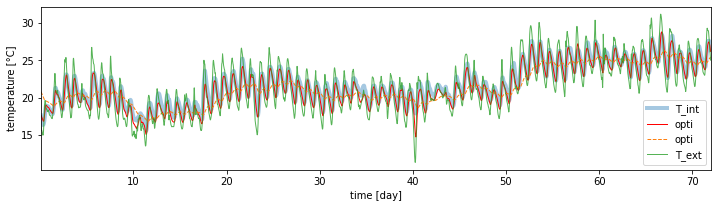

In [511]:
# Graph
T_opti = solve_3R2C(res.x)
plt.figure(figsize=(12, 3));
plt.plot(time/3600/24, T_int, label='T_int', linewidth=4, alpha=0.4);
plt.plot(time/3600/24, T_opti[0, :], 'r', label='opti', linewidth=1, alpha=1);
plt.plot(time/3600/24, T_opti[1, :], '--', label='opti', linewidth=1, alpha=1.0);
plt.plot(time/3600/24, T_ext, label='T_ext', linewidth=1, alpha=0.8);
plt.xlim([np.min(time)/3600/24, np.max(time)/3600/24])
plt.legend(); plt.xlabel('time [day]'); plt.ylabel('temperature [°C]');

(0.07291666666666667, 71.96875)

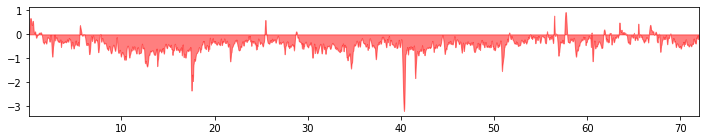

In [512]:
plt.figure(figsize=(12, 2));
plt.fill_between(time/3600/24, T_opti[0, :]-T_int, color='r', linewidth=1, alpha=0.5);
plt.xlim([np.min(time)/3600/24, np.max(time)/3600/24])

    M1:     4417.959  (1000.0)
    M2:   304898.195  (10000.0)
    k1:        0.115  (5)
    k2:        0.314  (5)
   T02:       21.143  (21)

In [154]:
def log_prior_expo(params):
    if np.any(params<0):
        return -np.inf
    else:
        return -np.sum(params)

In [534]:
def log_like(params):
    T = solve_3R2C(params)
    residuals = T[0, :] - T_int
    return -0.5 * np.sum(residuals**2)

lower_bounds = np.array([1e3,  0,  0])
upper_bounds = np.array([1e4, 0.5, 0.25])

def log_prior(theta):
    #M1, k1, k2, T02 = theta
    if any(t < b for t, b in zip(theta, lower_bounds)):
        return -np.inf
    elif any(t > b for t, b in zip(theta, upper_bounds)):
        return -np.inf
    else:
        return 0.0

def log_probability(params):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf, -np.inf
    ll = log_like(params)
    if not np.isfinite(ll):
        return lp, -np.inf
    return lp + ll, lp

In [452]:
ndim = len(lower_bounds)


In [454]:
for _ in range(10):
    p0_random = np.random.rand(ndim)*(upper_bounds - lower_bounds) + lower_bounds
    res = least_squares(residuals, p0_random, method='lm')
    if res.cost > 500:
        continue
    print('final cost value:', res.cost, '  n eval', res.nfev)
    print('\n'.join( [f' {n:>5}: {p:> 12.3f}  ({pzero:.3f})'
                      for n, p, pzero in zip(labels, res.x, p0_random)] ))

final cost value: 474.6822331987977   n eval 152
    M1:  67955802279.480  (3625.358)
    M2:  214739615156.796  (98652873.354)
    k1:  2343634.051  (3.029)
    k2:  5298162.616  (1.186)
   T02:       20.889  (16.527)
final cost value: 474.6822331568004   n eval 144
    M1: -358351465.310  (1613.305)
    M2: -1132400623.465  (24671177.066)
    k1:   -12358.644  (0.803)
    k2:   -27938.826  (0.933)
   T02:       20.889  (19.276)
final cost value: 474.6822331303511   n eval 101
    M1: -1039936.010  (9825.548)
    M2: -3286336.324  (11292686.327)
    k1:      -35.864  (1.989)
    k2:      -81.078  (4.847)
   T02:       20.889  (27.983)
final cost value: 239.81414094853983   n eval 210
    M1:  -736648.570  (8189.014)
    M2:  27700623.215  (25864492.422)
    k1:      -13.260  (0.854)
    k2:      -50.965  (3.343)
   T02:       20.747  (28.941)
final cost value: 239.81414139498582   n eval 197
    M1:  130155120.416  (5611.953)
    M2: -4894270491.940  (57204107.678)
    k1:     2342.82

In [409]:
p0 = p0_random

In [537]:
nwalkers = 10
ndim = len(p0)
pos = np.random.rand(nwalkers, ndim)*(upper_bounds - lower_bounds) + lower_bounds

In [538]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability)
sampler.run_mcmc(pos, 1000, progress=True);

100%|██████████| 1000/1000 [00:12<00:00, 82.58it/s]


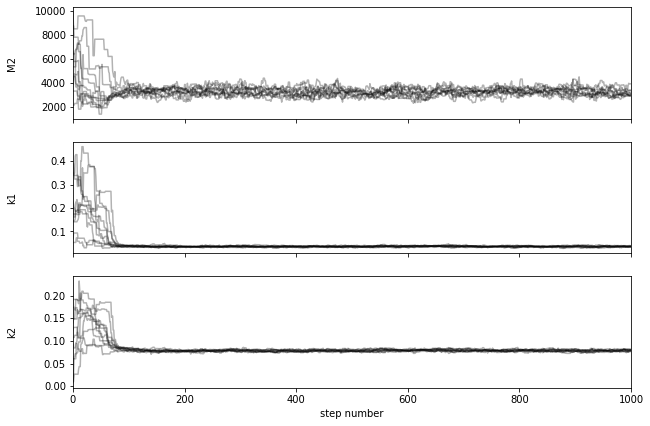

In [539]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [540]:
flat_samples = sampler.get_chain(discard=100, thin=1, flat=True)

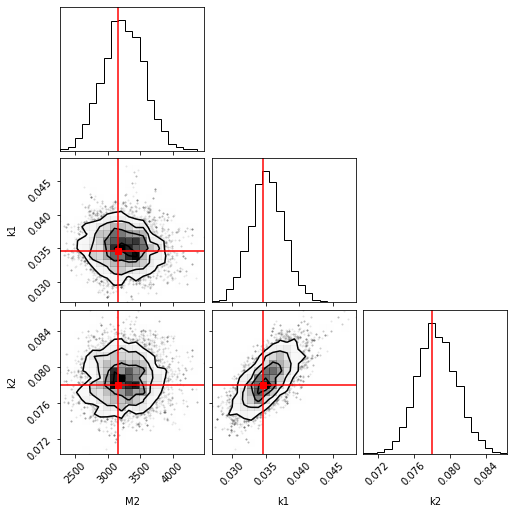

In [541]:
fig = corner.corner(
    flat_samples, labels=labels,
    truths=res.x, 
    truth_color='red',
);

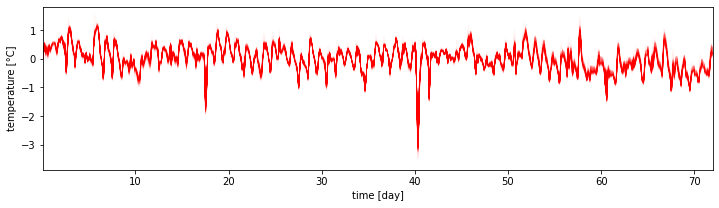

In [463]:
inds = np.random.randint(len(flat_samples), size=260)
plt.figure(figsize=(12, 3));
#plt.plot(time/3600/24, T_int, label='T_int', linewidth=4, alpha=0.4);
for ind in inds:
    sample = flat_samples[ind]
    #plt.plot(x0, np.dot(np.vander(x0, 2), sample[:2]), "C1", alpha=0.1)
    
    T_opti = solve_3R2C(sample)
    
    
    plt.plot(time/3600/24, T_opti[0, :]-T_int, 'r', linewidth=1, alpha=0.01);
    #plt.plot(time/3600/24, T_opti[1, :], '--', label='opti', linewidth=1, alpha=1.0);
    #plt.plot(time/3600/24, T_ext, label='T_ext', linewidth=1, alpha=0.8);
    
plt.xlim([np.min(time)/3600/24, np.max(time)/3600/24])
#plt.legend();
plt.xlabel('time [day]'); plt.ylabel('temperature [°C]');